# Summary

1. Dimensionality reduction of data through PCA
2. (AR)HMM to quantify dynamics of (dim-reduced) activity

In [1]:
import sys
sys.path.insert(0, '../../flygenvectors/')

import os
import numpy as np
from glob import glob
import scipy.io as sio
from scipy import sparse, signal

from sklearn.decomposition import PCA, FastICA
# from skimage.restoration import denoise_tv_chambolle

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
from scipy.stats import zscore
import data as dataUtils
# import plotting
# import utils

# from ssm import HMM
# from ssm.util import rle
# from ssm.primitives import hmm_sample, lds_sample
# from ssm.observations import GaussianObservations
# from ssm.init_state_distns import InitialStateDistribution
# from ssm.preprocessing import trend_filter

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score

In [2]:
sns.set_style("white")
sns.set_context("talk")

### load data

In [3]:
exp_date = '2019_07_01'
fly_num = 'fly2'
main_dir = '/Users/evan/Dropbox/_AxelLab/_flygenvectors_dataShare/'

exp_folder = exp_date + '_' + fly_num + '/'
file_name_main = exp_date + '*' + fly_num + '.npz'
file_name_A = exp_date + '*' + fly_num + '_A.npz'

file_path_main = glob(main_dir+exp_folder+file_name_main)[0]
# file_path_main = os.path.join(main_dir, exp_folder, file_name_main)
mat_contents = np.load(file_path_main)
# file_path_A = os.path.join(main_dir, exp_folder, file_name_A)
file_path_A = glob(main_dir+exp_folder+file_name_A)[0]
A = sparse.load_npz(file_path_A)

# trialFlag: indexes running/feeding/running components of the experiment
# dOO: ratiometric dF/F for every active cell
# A: spatial footprint of these cells
# ball, dlc: behavioral data

### preprocess data - split into training/testing sets

In [4]:
# get data from matlab dict
behavior = np.squeeze(mat_contents['ball'])
trialFlag = np.squeeze(mat_contents['trialFlag'])
dlc_behav = np.squeeze(mat_contents['dlc'])
time = np.squeeze(mat_contents['time'])
dFF = np.squeeze(mat_contents['dFF'])
dims = np.squeeze(mat_contents['dims'])


### remove cells with probable motion artifacts

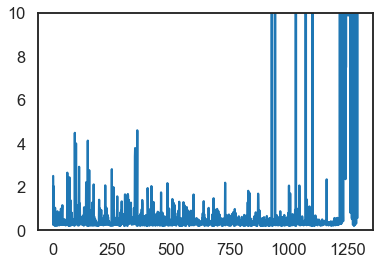

In [5]:
motionThreshold = 10 # signal this large is probably artifact
mx = np.amax(dFF,axis=1)
plt.figure
plt.plot(mx)
plt.ylim(0,motionThreshold)
motionFlag = mx<motionThreshold
dFF = dFF[motionFlag,:]
A = A[:,motionFlag]

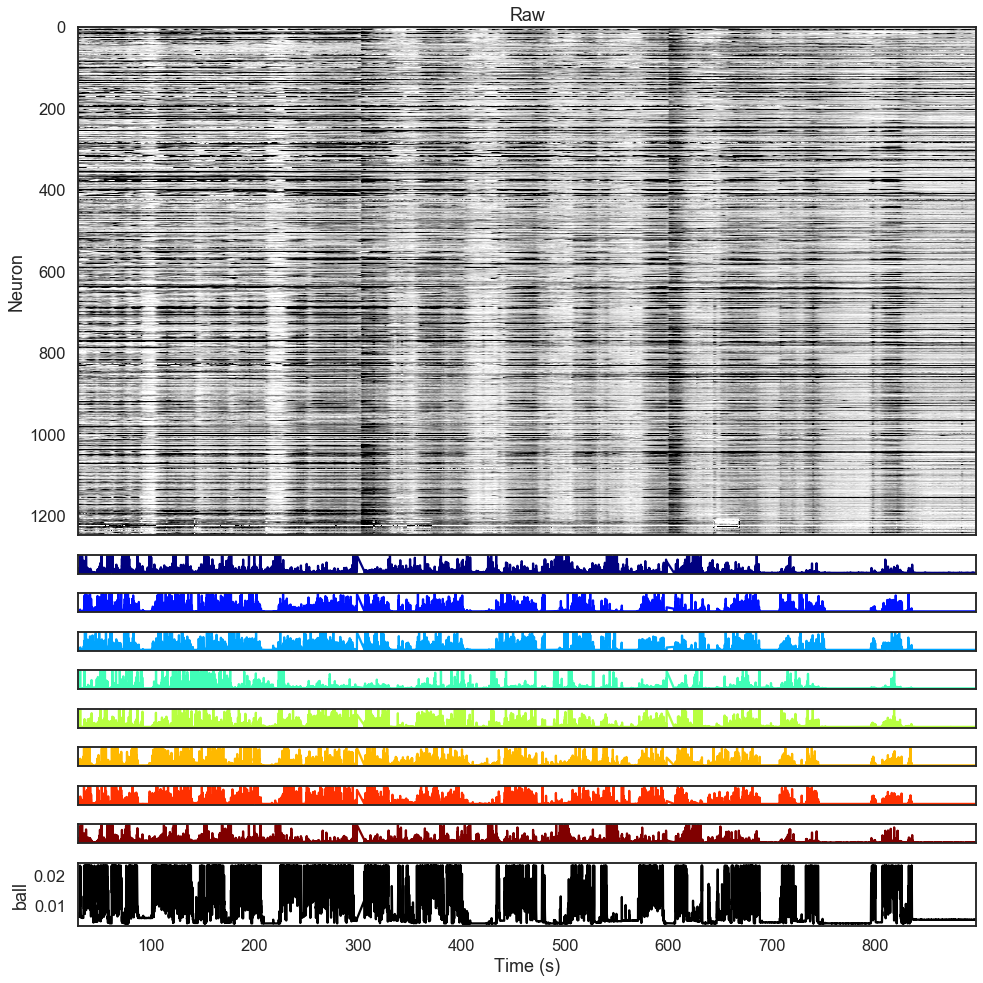

In [6]:
# preprocess
bmin = np.quantile(behavior, 0.1)
bmax = np.quantile(behavior, 0.9)
behavior[behavior<bmin]=bmin
behavior[behavior>bmax]=bmax

# data_run = zscore(dFF)
# data_run = signal.detrend(data_run, axis=0)
dFFc = dFF #dataUtils.cluster(dFF)

nDLCpts=8 #np.shape(dlc_behav)[1]/3
colors = pl.cm.jet(np.linspace(0,1,nDLCpts))

vmin = np.quantile(dFFc, 0.01)
vmax = np.quantile(dFFc, 0.95)
dFFc[dFFc<vmin]=vmin
dFFc[dFFc>vmax]=vmax

# plt.figure(figsize=(12, 28))
f, axes = plt.subplots(10,1,gridspec_kw={'height_ratios':[8,.3,.3,.3,.3,.3,.3,.3,.3,1]},figsize=(14, 14))
#f.set_figsize([12,12])
#plt.subplot(121)



axes[0].imshow(
    dFF, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.sca(axes[0])
plt.title('Raw')
axes[0].set_xlim([0,len(behavior)])
plt.xticks([])
plt.ylabel('Neuron')

for i in range(nDLCpts):
    plt.sca(axes[1+i])
    
    xdataChunk = np.diff(dlc_behav[:,(i-1)*3]); 
    ydataChunk = np.diff(dlc_behav[:,1+(i-1)*3]);
    legEnergy = xdataChunk**2 + ydataChunk**2;
    m = np.quantile(legEnergy, 0.01)
    M = np.quantile(legEnergy, 0.99)
    legEnergy[legEnergy<m]=m
    legEnergy[legEnergy>M]=M
    #     legEnergy = denoise_tv_chambolle(legEnergy, weight=1.0)
    
    axes[1+i].plot(time[:-1],legEnergy,color=colors[i])
    axes[1+i].set_xlim([min(time),max(time)])
    plt.xticks([])
    plt.yticks([])
    

plt.sca(axes[-1])
axes[-1].plot(time,behavior,'k')
axes[-1].set_xlim([min(time),max(time)])
axes[-1].set_ylabel('ball')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

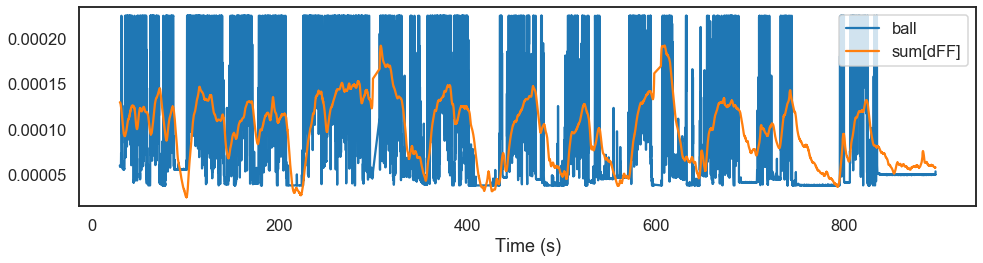

In [7]:
# summed neural data lags behind behavioral data, but derivative is aligned in time
dFFsum = np.sum(dFFc,axis=0)/np.sum(dFFc)
plt.figure(figsize=(14, 4))
plt.plot(time, behavior/np.sum(behavior))
plt.plot(time, dFFsum)
plt.xlabel('Time (s)')
plt.legend(('ball','sum[dFF]'))
plt.tight_layout()
plt.show()

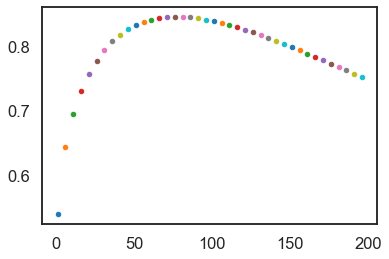

In [8]:
# find optimal time constant with which to filter ball trace to maximize correlation with summed neural activity
cTau = 1
x = np.array([i for i in range(1000)])

plt.figure
tauList = range(1,200,5)
a = np.zeros(np.shape(tauList))
for i in range(len(tauList)):
    cTau = tauList[i]
    
    eFilt = np.exp(-x/cTau)

    c = np.convolve(eFilt,behavior)#,'same')
    c = c[:len(behavior)]
    
    a[i] = np.corrcoef(dFFsum, c)[0,1]
    plt.plot(cTau,a[i],'.')
plt.show()

Optimal tau = 76 frames, equals 6.33 sec.  Corrcoef w/ behav = 0.85


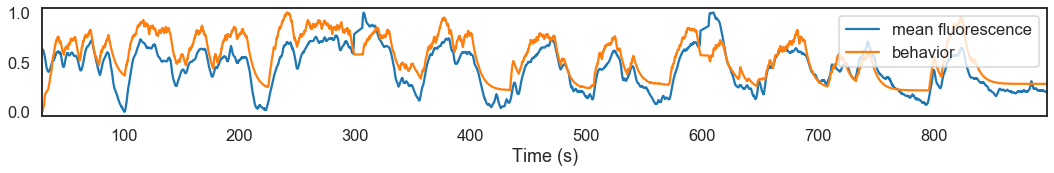

In [9]:
# show optimally smoothed ball trace

cTau=tauList[np.argmax(a)]
print('Optimal tau = '+str(cTau)+' frames, equals '+"{:.2f}".format(cTau/12.)+' sec.  Corrcoef w/ behav = '+"{:.2f}".format(np.max(a)))
eFilt = np.exp(-x/cTau)

behConv = np.convolve(eFilt,behavior)#,'same')
behConv = behConv[:len(behavior)]

f = dFFsum #[:-wd]
m = np.min(f)
M = np.max(f)
f = (f-m)/(M-m)

m = np.min(behConv)
M = np.max(behConv)
behConv = (behConv-m)/(M-m)

plt.figure(figsize=(18, 2))
plt.plot(time, f, label='mean fluorescence')
plt.plot(time, behConv, label='behavior')
plt.legend() #(frameon=False)
plt.xlim((time[0],time[-1]))
plt.xlabel('Time (s)')
plt.show()

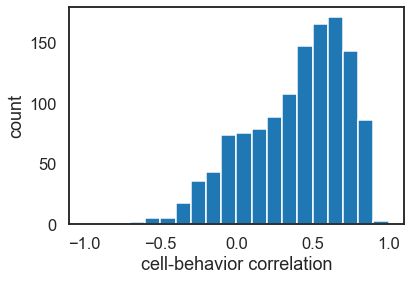

In [10]:
# show correlation of individual cells with behavior

cc = np.zeros(np.shape(dFFc)[0])
for i in range(np.shape(dFFc)[0]):
    cc[i] = np.corrcoef(behConv, dFFc[i,:])[0,1]

plt.hist(cc,np.linspace(-1,1,21))
plt.xlabel('cell-behavior correlation')
plt.ylabel('count')
plt.show()

### regress out smoothed ball trace from all cells


/Users/evan/anaconda/envs/flygenvectors/lib/python3.6/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


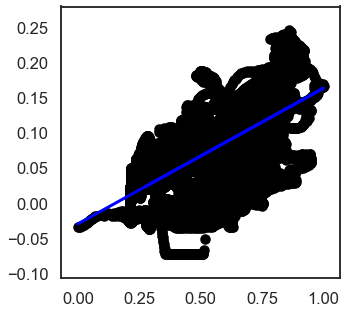

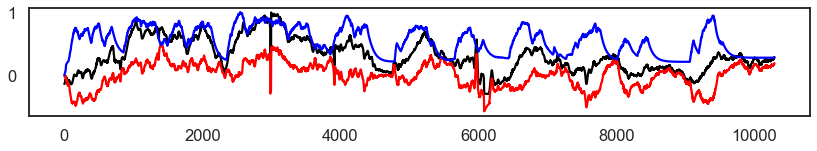

In [11]:
# regress out smoothed ball trace from an example cell
behConvA = behConv.reshape(-1, 1)

regr = LinearRegression()
dFFresid = np.zeros(np.shape(dFFc))
# for i in range(np.shape(dFFc)[0]):
i=1
f = regr.fit(behConvA, dFFc[i,:])
fp = regr.predict(behConvA)

plt.figure(figsize=(5, 5))
plt.scatter(behConv, dFFc[i,:],  color='black')
plt.plot(behConv, fp, color='blue', linewidth=3)
plt.show()

plt.figure(figsize=(14, 2))
plt.plot(dFFc[i,:]/np.max(dFFc[i,:]),'k')
plt.plot( (dFFc[i,:]-fp)/np.max(dFFc[i,:]),'r')
plt.plot(behConv,'b')
plt.show()


In [12]:

# regress out smoothed behavior traces from all cells
behConvA = behConv.reshape(-1, 1)
dlcConv = np.zeros( (np.shape(dlc_behav)[0]-1,nDLCpts+1) )
dlcConv[:,0] = np.squeeze(behConvA[:-1])

for j in range(nDLCpts):
    xdataChunk = np.diff(dlc_behav[:,(j-1)*3]); 
    ydataChunk = np.diff(dlc_behav[:,1+(j-1)*3]);
    legEnergy = xdataChunk**2 + ydataChunk**2;
    c = np.convolve(eFilt,legEnergy)#,'same')
    c = c[:len(legEnergy)]
    m = np.min(c)
    M = np.max(c)
    dlcConv[:,j+1] = (c-m)/(M-m)
    dlcConv[:,j+1] = np.squeeze(dlcConv[:,j+1].reshape(-1, 1))


regr = LinearRegression()
dFFresid = np.zeros(np.shape(dFFc[:,:-1]))
for i in range(np.shape(dFFc)[0]):
    fsample = dFFc[i,:-1]
    regr.fit(dlcConv, fsample)
    fp = regr.predict(dlcConv)
    dFFresid[i,:] = fsample-fp



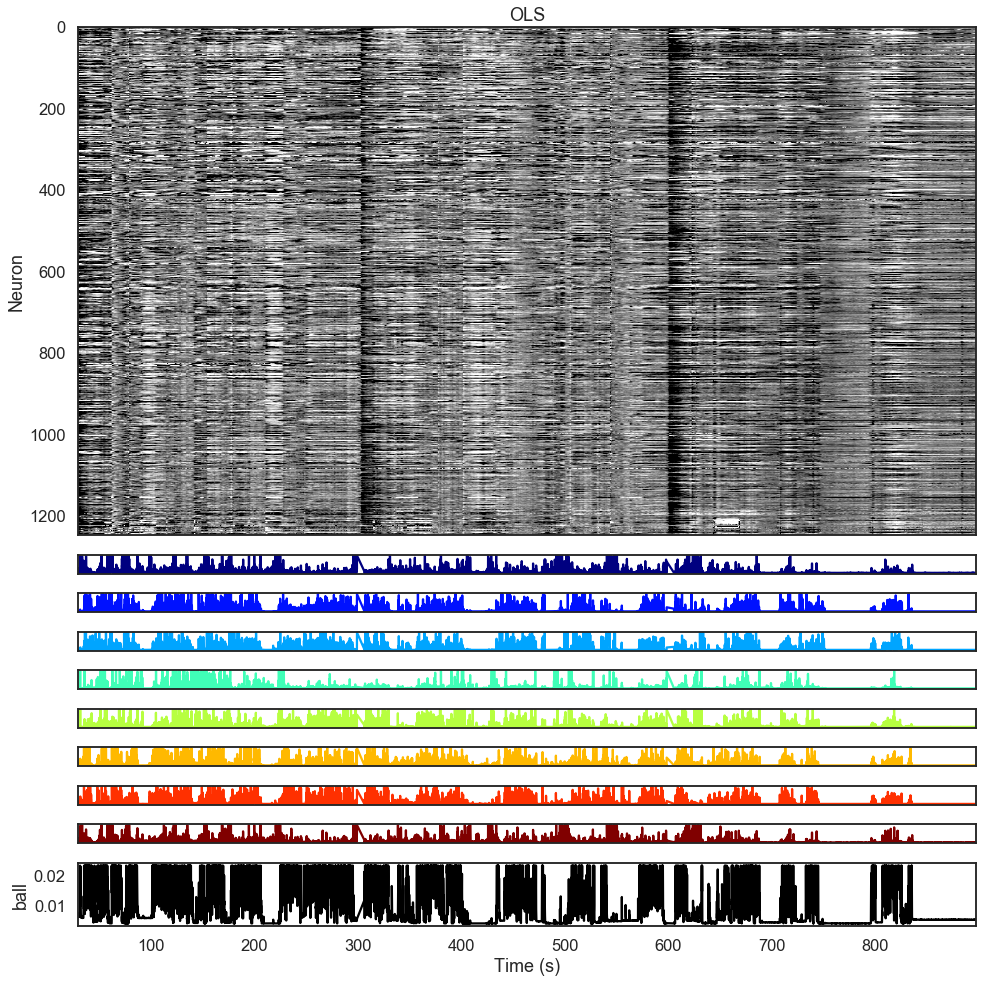

In [13]:
# plot regression residual

vmin = np.quantile(dFFresid, 0.01)
vmax = np.quantile(dFFresid, 0.95)
# dFFresid[dFFresid<vmin]=vmin
# dFFresid[dFFresid>vmax]=vmax

# plt.figure(figsize=(12, 28))
f, axes = plt.subplots(10,1,gridspec_kw={'height_ratios':[8,.3,.3,.3,.3,.3,.3,.3,.3,1]},figsize=(14, 14))
#f.set_figsize([12,12])
#plt.subplot(121)



axes[0].imshow(
    dFFresid, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.sca(axes[0])
plt.title('OLS')
axes[0].set_xlim([0,len(behavior)])
plt.xticks([])
plt.ylabel('Neuron')

for i in range(nDLCpts):
    plt.sca(axes[1+i])
    
    xdataChunk = np.diff(dlc_behav[:,(i-1)*3]); 
    ydataChunk = np.diff(dlc_behav[:,1+(i-1)*3]);
    legEnergy = xdataChunk**2 + ydataChunk**2;
    m = np.quantile(legEnergy, 0.01)
    M = np.quantile(legEnergy, 0.99)
    legEnergy[legEnergy<m]=m
    legEnergy[legEnergy>M]=M
    #     legEnergy = denoise_tv_chambolle(legEnergy, weight=1.0)
    
    axes[1+i].plot(time[:-1],legEnergy,color=colors[i])
    axes[1+i].set_xlim([min(time),max(time)])
    plt.xticks([])
    plt.yticks([])
    

plt.sca(axes[-1])
axes[-1].plot(time,behavior,'k')
axes[-1].set_xlim([min(time),max(time)])
axes[-1].set_ylabel('ball')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

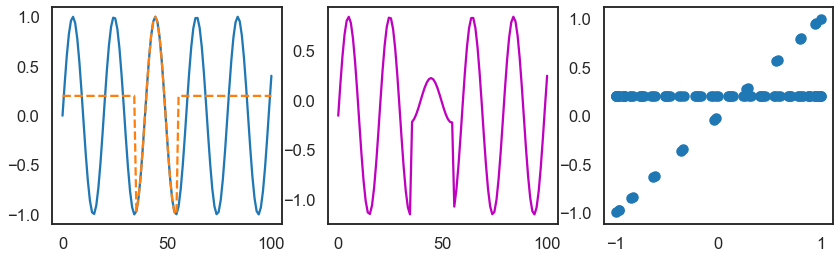

In [14]:
# project out ball component from activity

t = np.linspace(0,100,100)
a = np.sin(t/np.pi)
b = .2+np.zeros(np.shape(a))
b[35:55] = a[35:55]

a1 = np.dot(a,b)/np.linalg.norm(b)
a1v = a1*b/np.linalg.norm(b)
a2v = a-a1v

plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
plt.plot(t,a)
plt.plot(t,b,'--')

plt.subplot(1,3,2)
plt.plot(t,a2v,'m')

plt.subplot(1,3,3)
plt.scatter(a,b)
plt.show()

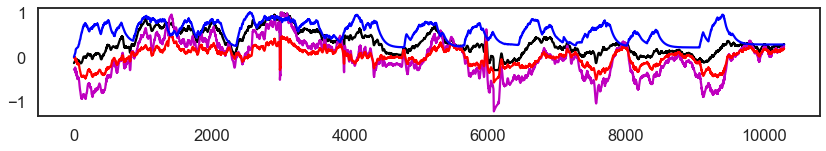

In [15]:
# project out smoothed ball trace from an example cell
i=1
a = dFFc[i,:]
b = behConvA
a1 = np.dot(a,b)[0]/np.linalg.norm(b)
a1v = np.squeeze(a1*b/np.linalg.norm(b))
a2v = np.subtract(a,a1v)

f = regr.fit(behConvA, dFFc[i,:])
fp = regr.predict(behConvA)



plt.figure(figsize=(14, 2))
plt.plot(dFFc[i,:]/np.max(dFFc[i,:]),'k')
plt.plot( a2v/np.max(a2v),'m')
plt.plot( (dFFc[i,:]-fp)/np.max(dFFc[i,:]),'r')
plt.plot(behConv,'b')
plt.show()

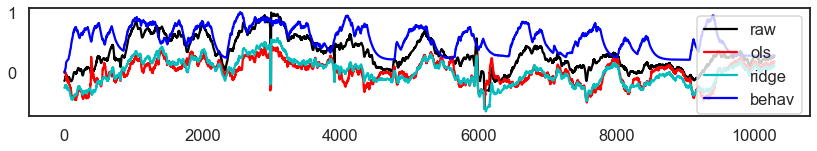

[[1.         0.71582377]
 [0.71582377 1.        ]]
[[1.         0.93336396]
 [0.93336396 1.        ]]


In [16]:
# regress out ALL BEHAVIOR TRACES from an example cell
behConvA = behConv.reshape(-1, 1)
dlcConv = np.zeros( (np.shape(dlc_behav)[0]-1,nDLCpts+1) )
dlcConv[:,0] = np.squeeze(behConvA[:-1])

for j in range(nDLCpts):
    xdataChunk = np.diff(dlc_behav[:,(j-1)*3]); 
    ydataChunk = np.diff(dlc_behav[:,1+(j-1)*3]);
    legEnergy = xdataChunk**2 + ydataChunk**2;
    c = np.convolve(eFilt,legEnergy)#,'same')
    c = c[:len(legEnergy)]
    m = np.min(c)
    M = np.max(c)
    dlcConv[:,j+1] = (c-m)/(M-m)
    dlcConv[:,j+1] = np.squeeze(dlcConv[:,j+1].reshape(-1, 1))
    

i=1
fsample = dFFc[i,:-1]

# ols
regr = LinearRegression()
f = regr.fit(dlcConv, fsample)
fpA = regr.predict(dlcConv)

# ridge
regr = Ridge(alpha=1000)
fR = regr.fit(dlcConv, fsample)
fpAR = regr.predict(dlcConv)

plt.figure(figsize=(14, 2))
plt.plot(fsample/np.max(fsample),'k',label='raw')
plt.plot( (fsample-fpA)/np.max(fsample),'r',label='ols')
plt.plot( (fsample-fpAR)/np.max(fsample),'c',label='ridge')
# plt.plot( (dFFc[i,:]-fp)/np.max(dFFc[i,:]),'m')
plt.plot(behConv,'b',label='behav')
plt.legend() #(frameon=False)
plt.show()

print(np.corrcoef(fsample,fsample-fpA))
print(np.corrcoef(fsample,fsample-fpAR))

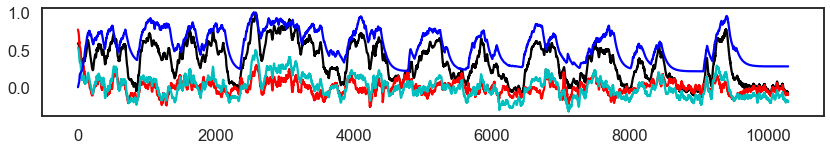

[[1.         0.38820107]
 [0.38820107 1.        ]]
[[1.         0.89400509]
 [0.89400509 1.        ]]


In [17]:
# another cell (most correlated with behavior)
i=np.argmax(cc)
fsample = dFFc[i,:-1]

# ols
regr = LinearRegression()
f = regr.fit(dlcConv, fsample)
fpA = regr.predict(dlcConv)

# ridge
regr = Ridge(alpha=1000)
fR = regr.fit(dlcConv, fsample)
fpAR = regr.predict(dlcConv)

plt.figure(figsize=(14, 2))
plt.plot(fsample/np.max(fsample),'k')
plt.plot( (fsample-fpA)/np.max(fsample),'r')
plt.plot( (fsample-fpAR)/np.max(fsample),'c')
# plt.plot( (dFFc[i,:]-fp)/np.max(dFFc[i,:]),'m')
plt.plot(behConv,'b')
plt.show()

print(np.corrcoef(fsample,fsample-fpA))
print(np.corrcoef(fsample,fsample-fpAR))

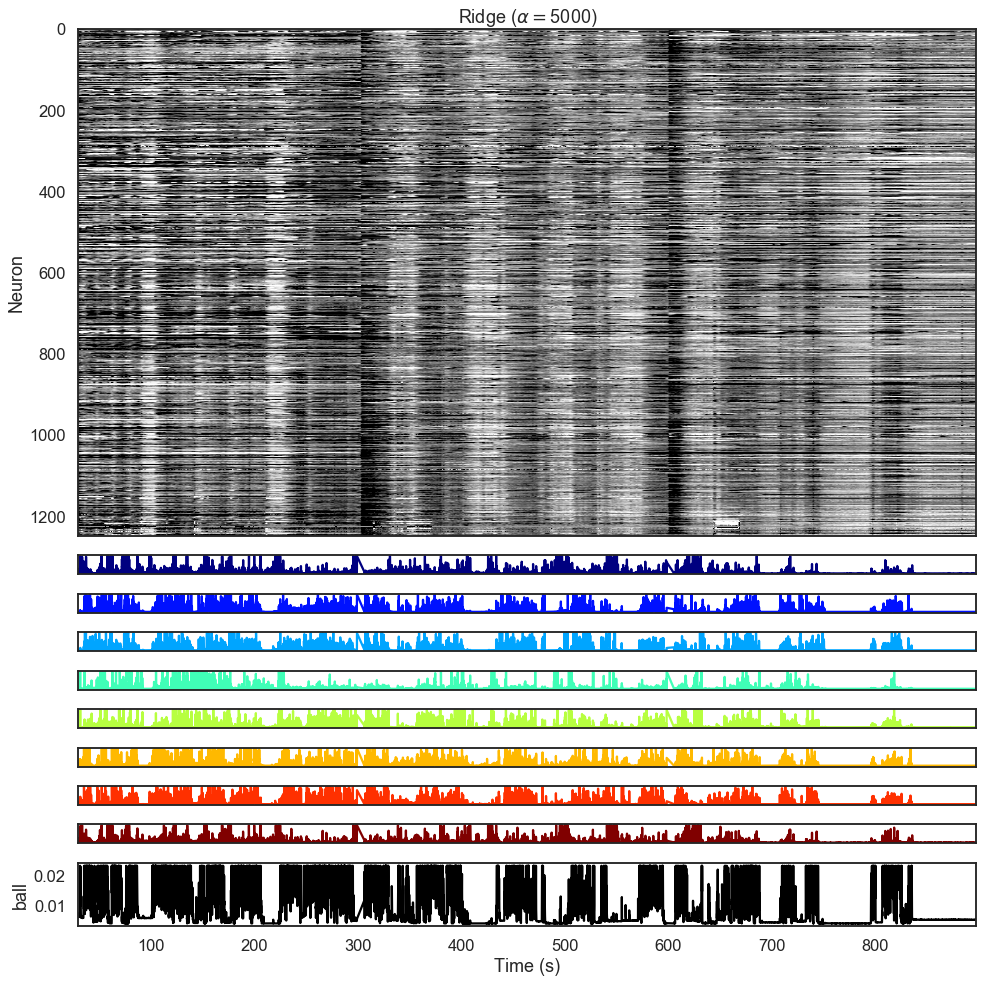

In [18]:
# regress out behavior from all cells
alpha=5000
regr = Ridge(alpha=alpha)
dFFresid_ridge = np.zeros(np.shape(dFFc[:,:-1]))
for i in range(np.shape(dFFc)[0]):
    fsample = dFFc[i,:-1]
    regr.fit(dlcConv, fsample)
    fpAR = regr.predict(dlcConv)
    dFFresid_ridge[i,:] = fsample-fpAR

vmin = np.quantile(dFFresid_ridge, 0.01)
vmax = np.quantile(dFFresid_ridge, 0.95)

# plot stuff
f, axes = plt.subplots(10,1,gridspec_kw={'height_ratios':[8,.3,.3,.3,.3,.3,.3,.3,.3,1]},figsize=(14, 14))

axes[0].imshow(
    dFFresid_ridge, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.sca(axes[0])
plt.title(r'Ridge ($\alpha=$'+str(alpha)+')')
axes[0].set_xlim([0,len(behavior)])
plt.xticks([])
plt.ylabel('Neuron')

for i in range(nDLCpts):
    plt.sca(axes[1+i])
    
    xdataChunk = np.diff(dlc_behav[:,(i-1)*3]); 
    ydataChunk = np.diff(dlc_behav[:,1+(i-1)*3]);
    legEnergy = xdataChunk**2 + ydataChunk**2;
    m = np.quantile(legEnergy, 0.01)
    M = np.quantile(legEnergy, 0.99)
    legEnergy[legEnergy<m]=m
    legEnergy[legEnergy>M]=M
    #     legEnergy = denoise_tv_chambolle(legEnergy, weight=1.0)
    
    axes[1+i].plot(time[:-1],legEnergy,color=colors[i])
    axes[1+i].set_xlim([min(time),max(time)])
    plt.xticks([])
    plt.yticks([])
    

plt.sca(axes[-1])
axes[-1].plot(time,behavior,'k')
axes[-1].set_xlim([min(time),max(time)])
axes[-1].set_ylabel('ball')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

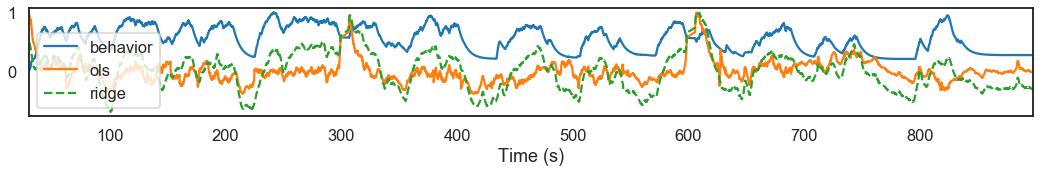

In [19]:
# compare regression residuals

sols = np.sum(dFFresid,axis=0)
sridge = np.sum(dFFresid_ridge,axis=0)

plt.figure(figsize=(18, 2))
plt.plot(time[:-1], behConv[:-1], label='behavior')
plt.plot(time[:-1], sols/np.max(sols), label='ols')
plt.plot(time[:-1], sridge/np.max(sridge),'--', label='ridge')
plt.legend() #(frameon=False)
plt.xlim((time[0],time[-1]))
plt.xlabel('Time (s)')
plt.show()